In [ ]:
#!pip install pyreadr
#!wget -O 48_-_breast_cancer_data.RData "https://zenodo.org/records/7657781/files/48_-_breast_cancer_data.RData?download=1"

import pyreadr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


raw_data = pyreadr.read_r('48_-_breast_cancer_data.RData')['out']
raw_data.to_csv('dataset')

df = raw_data.copy()

df = df.drop(index=1285)
df

# break-down of age vs target

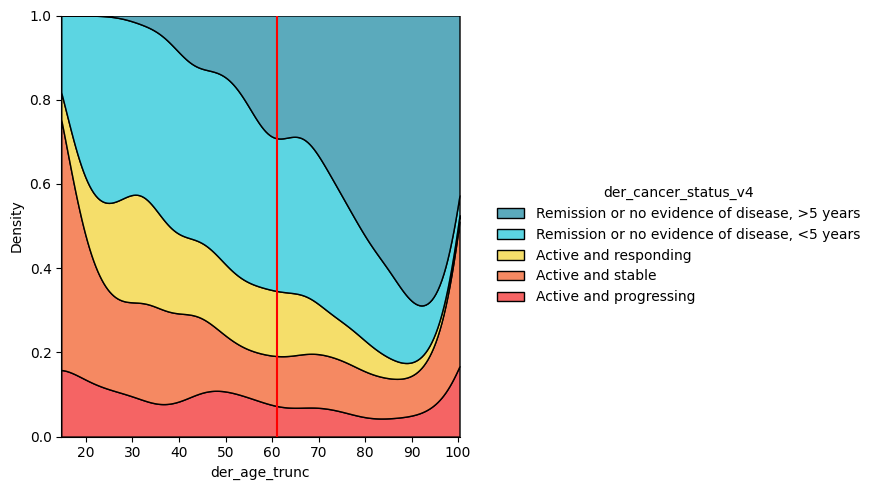

In [218]:
df_reg = df[['der_age_trunc', 'der_cancer_status_v4', 'severity_of_covid_19_v2']].dropna()
df_reg['active_cancer'] = df_reg['der_cancer_status_v4'].map(lambda x: 'Active' in x)
df_reg['moderate_severe_covid'] = df_reg['severity_of_covid_19_v2'].map(lambda x: 'Active' in x)


median_age = df_reg['der_age_trunc'].median()


hue_order = ['Active and progressing',  'Active and stable', 'Active and responding', 'Remission or no evidence of disease, <5 years', 'Remission or no evidence of disease, >5 years'][::-1]

colors = ["#248EA6", "#25C7D9", "#F2D338", "#F2622E", "#F23030"]
# Set your custom color palette
palette = sns.color_palette(colors)


df_reg = df_reg[df_reg['der_cancer_status_v4'] != 'Unknown']
sns.displot(df_reg, x="der_age_trunc", kind="kde", hue = 'der_cancer_status_v4', multiple="fill", palette=palette, hue_order=hue_order)
plt.vlines(x = median_age, ymin = 0, ymax = 1,
           colors = 'red',
           label = 'vline_multiple - full height')


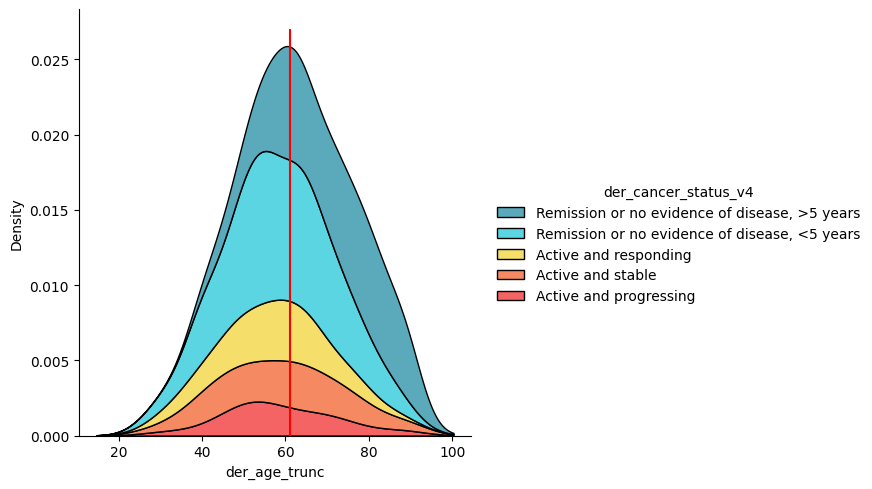

In [220]:
sns.displot(df_reg, x="der_age_trunc", kind="kde", hue = 'der_cancer_status_v4', multiple="stack", palette=palette, hue_order=hue_order)
plt.vlines(x = median_age, ymin = 0, ymax = .027,
           colors = 'red',
           label = 'vline_multiple - full height')


In [141]:
df.der_cancer_status_v4.unique()

['Active and responding', 'Active and stable', NaN, 'Unknown', 'Remission or no evidence of disease, <5 years', 'Active and progressing', 'Remission or no evidence of disease, >5 years']
Categories (6, object): ['Active and progressing', 'Active and responding', 'Active and stable',
                         'Remission or no evidence of disease, <5 years', 'Remission or no evidence of disease, >5 years',
                         'Unknown']

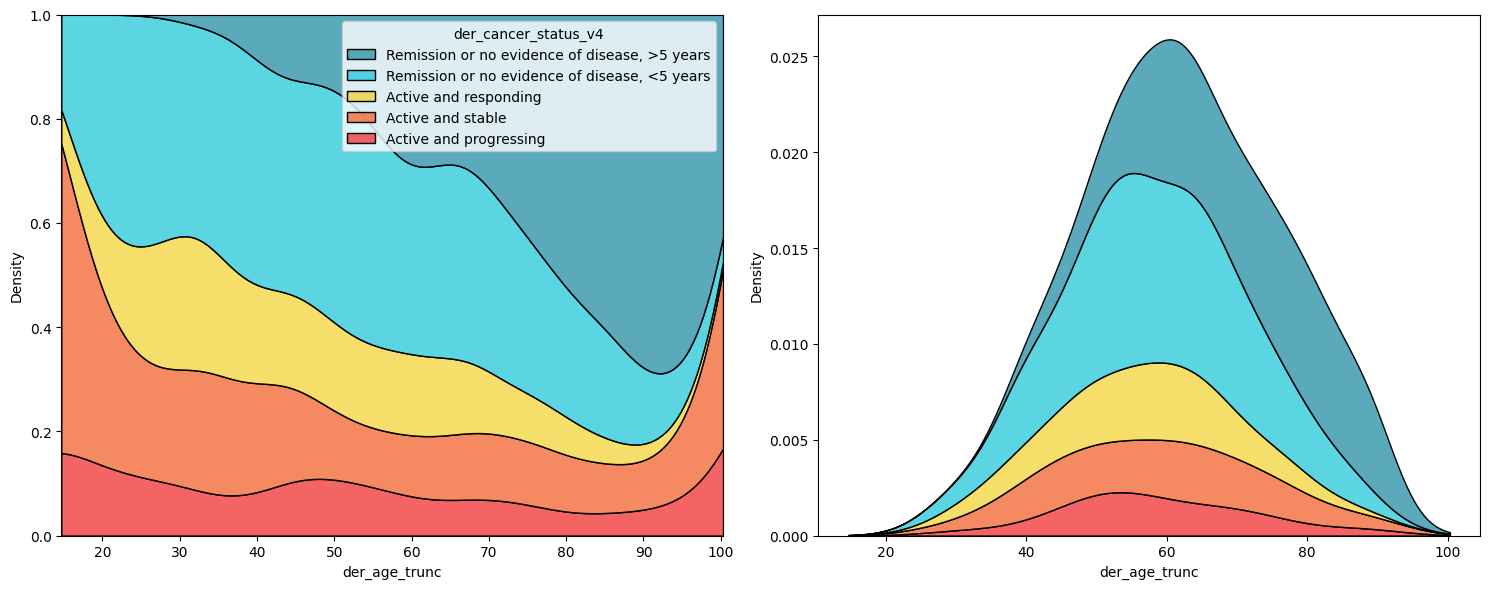

In [216]:
# Creating the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# And then, from here onwards, it's exactly like

# palette=sns.color_palette("deep")

# First plot
sns.kdeplot(data=df_reg, x="der_age_trunc", hue='der_cancer_status_v4', multiple="fill", ax=axes[0], palette=palette, hue_order=hue_order)

# Second plot
sns.kdeplot(data=df_reg, x="der_age_trunc", hue='der_cancer_status_v4', multiple="stack", ax=axes[1], palette=palette, hue_order=hue_order)

# Adjust the layout
plt.tight_layout()

#axes[0].legend(hue_order, loc='lower right')
axes[1].get_legend().remove()

# Display the plot
plt.show()

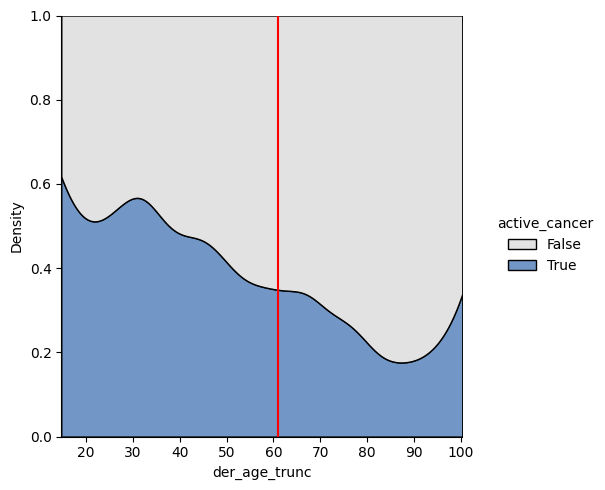

In [144]:
sns.displot(df_reg, x="der_age_trunc", kind="kde", hue = 'active_cancer', multiple="fill")

plt.vlines(x = median_age, ymin = 0, ymax = 1,
           colors = 'red',
           label = 'vline_multiple - full height')


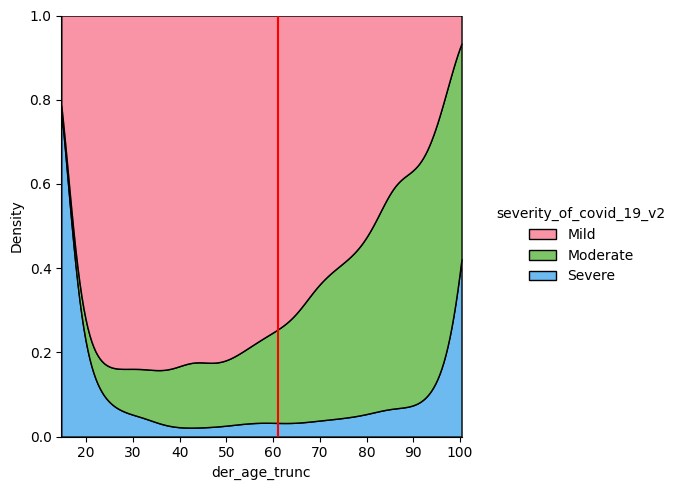

In [145]:
sns.displot(df_reg, x="der_age_trunc", kind="kde", hue = 'severity_of_covid_19_v2', multiple="fill")
plt.vlines(x = median_age, ymin = 0, ymax = 1,
           colors = 'red',
           label = 'vline_multiple - full height')


In [146]:
df['der_cancer_status_v4'].unique()



['Active and responding', 'Active and stable', NaN, 'Unknown', 'Remission or no evidence of disease, <5 years', 'Active and progressing', 'Remission or no evidence of disease, >5 years']
Categories (6, object): ['Active and progressing', 'Active and responding', 'Active and stable',
                         'Remission or no evidence of disease, <5 years', 'Remission or no evidence of disease, >5 years',
                         'Unknown']

In [ ]:
help(sns.displot)

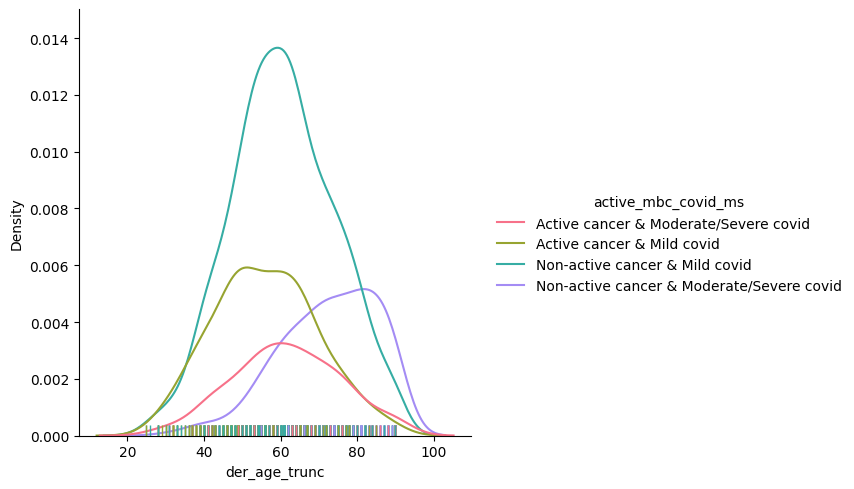

In [213]:
df_reg['active-cancer'] = df_reg['der_cancer_status_v4'].map(lambda x: 'Active' in x)
active_mbc_covid_ms = []
for a, c in df_reg[['active-cancer', 'severity_of_covid_19_v2']].values:
  x = 'Non-active cancer & '
  if a:
    x = 'Active cancer & '

  if c != 'Mild':
    x += 'Moderate/Severe covid'
  else:
    x += 'Mild covid'
  active_mbc_covid_ms.append(x)

df_reg['active_mbc_covid_ms'] = active_mbc_covid_ms
# sns.displot(df_reg, x="der_age_trunc", kind="kde", hue = 'active_mbc_covid_ms', multiple="fill", hue_order=['Non-active cancer & Mild covid', 'Non-active cancer & Moderate/Severe covid', 'Active cancer & Mild covid', 'Active cancer & Moderate/Severe covid'])
sns.displot(df_reg, x="der_age_trunc", kind="kde", hue='active_mbc_covid_ms', rug=True)

# test for outliers in age

In [ ]:
quartiles = df['der_age_trunc'].quantile([0.25,0.5,0.75]).values
iqr = quartiles[-1] - quartiles[0]
quartiles, iqr

(array([51., 61., 72.]), 21.0)

In [ ]:
ages = df['der_age_trunc'].values
outliers = [x for x in ages if ((x < (quartiles[0] - (1.5*iqr))) | (x > (quartiles[2] + (1.5*iqr))))]
print(f'There are {len(outliers)} outliers based on age')

There are 0 outliers based on age


der_age_trunc    Axes(0.125,0.11;0.775x0.77)
dtype: object

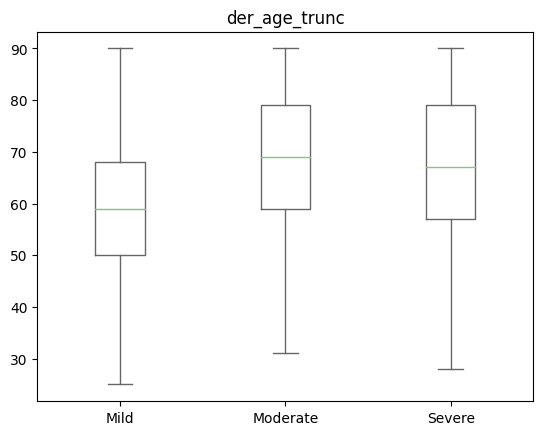

In [168]:
df_reg.plot(kind='box', column="der_age_trunc", by="severity_of_covid_19_v2", cmap='Accent_r')

## determine if there are any potential outliers across all cancer statuses

In [ ]:
help(sns.boxplot)

In [107]:
df_reg.der_cancer_status_v4.unique()

['Active and responding', 'Active and stable', 'Remission or no evidence of disease, <5 years', 'Active and progressing', 'Remission or no evidence of disease, >5 years']
Categories (6, object): ['Active and progressing', 'Active and responding', 'Active and stable',
                         'Remission or no evidence of disease, <5 years', 'Remission or no evidence of disease, >5 years',
                         'Unknown']

Text(0, 0.5, 'Cancer Status')

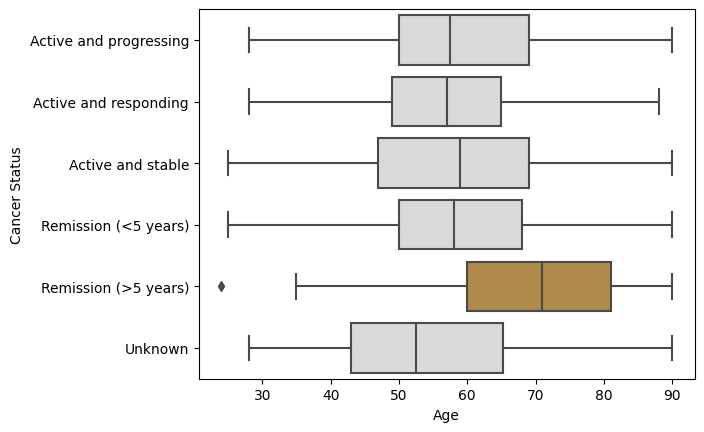

In [137]:
df_reg = raw_data[['der_age_trunc', 'der_cancer_status_v4']].dropna()
grey = (217, 217, 217)
rename  = {'Active and responding': 'Active and responding',
           'Active and stable': 'Active and stable',
           'Unknown': 'Unknown',
           'Remission or no evidence of disease, <5 years': 'Remission (<5 years)',
           'Active and progressing': 'Active and progressing',
           'Remission or no evidence of disease, >5 years': 'Remission (>5 years)'}
df_reg['der_cancer_status_v4'] = df_reg['der_cancer_status_v4'].map(lambda x: rename[x])
import seaborn as sns
colors = ["#D9D9D9", "#D9D9D9", "#D9D9D9", "#D9D9D9", "#BF9039"]

sns.boxplot(data=df_reg, x="der_age_trunc", y="der_cancer_status_v4", palette=sns.color_palette(colors))
plt.xlabel('Age')
plt.ylabel('Cancer Status')

In [109]:
df_reg['der_cancer_status_v4'].unique()

['Active and responding', 'Active and stable', 'Unknown', 'Remission (<5 years)', 'Active and progressing', 'Remission (>5 years)']
Categories (6, object): ['Active and progressing', 'Active and responding', 'Active and stable',
                         'Remission (<5 years)', 'Remission (>5 years)', 'Unknown']

In [129]:
df_rem = df_reg[df_reg['der_cancer_status_v4'] == 'Remission (>5 years)']

quartiles = df_rem['der_age_trunc'].quantile([0.25,0.5,0.75]).values
iqr = quartiles[-1] - quartiles[0]

ages = df_rem['der_age_trunc'].values
outlier_index = []
outliers = (ages < (quartiles[0] - (1.5*iqr))) + (ages > (quartiles[2] + (1.5*iqr)))

print(f'There are {sum(outliers)} outliers based on age')

There are 1 outliers based on age


In [177]:
outlier_index = df_rem[outliers].index
outlier_index

Int64Index([1285], dtype='int64')

In [178]:
raw_data.loc[outlier_index].iloc[0].to_dict() # ['der_smoking2': 'No', 'der_obesity': 'No', 'severity_of_covid_19_v2': 'Mild','der_region_v2': 'Northeast']

{'der_ordinal_v1a': 0,
 'der_days_fu': 90.0,
 'der_deadbinary': 'No',
 'der_dead30': 'No',
 'der_mv': 'No',
 'der_ICU': 'No',
 'der_hosp': 'No',
 'der_AKI_comp': 'No',
 'der_MOF_comp': 'No',
 'der_coinfection_any': 'No',
 'der_sepsis_comp': 'No',
 'der_bleeding_comp': 'No',
 'der_rem': 'No',
 'der_hcq': 'No',
 'der_steroids_c19': 'No',
 'der_other_tx_c19_v2': 'No',
 'der_o2_ever': 'No',
 'der_race_v2': 'Non-Hispanic White',
 'der_insurance': 'Private +/- other',
 'der_smoking2': 'Never',
 'der_obesity': 'No',
 'der_card': 'No',
 'der_pulm': 'No',
 'der_renal': 'No',
 'der_dm2': 'No',
 'der_ecogcat2': '0',
 'der_breast_biomarkers': 'HER2+',
 'der_cancer_status_v4': 'Remission or no evidence of disease, >5 years',
 'der_cancer_tx_timing_v2': '>3 months',
 'der_cancertr_none': 'Yes',
 'der_any_cyto': 'No',
 'der_any_targeted': 'No',
 'der_her2_3m': 'No',
 'der_cdk46i_3m': 'No',
 'der_other_3m': 'No',
 'der_any_endo': 'No',
 'der_any_immuno': 'No',
 'der_any_local': 'No',
 'der_any_other':

In [179]:
df_reg = df[['der_deadbinary', 'severity_of_covid_19_v2']].dropna()


# Creating a contingency table
contingency_table = pd.crosstab(df_reg['der_deadbinary'], df_reg['severity_of_covid_19_v2'])

contingency_table

severity_of_covid_19_v2,Mild,Moderate,Severe
der_deadbinary,,,
No,941,284,24
Yes,17,75,31
